In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [43]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 10
BS = 32

In [27]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images("dataset"))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    
    if label == 'with_mask':
        label = [1]
    else:
        label = [0]

    # load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

[INFO] loading images...


In [28]:
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)



In [34]:
print(labels.shape)
data.shape

(3846, 1)


(3846, 224, 224, 3)

In [41]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [36]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [45]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)

In [46]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [47]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])


[INFO] compiling model...


In [48]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] training head...
Epoch 1/10
96/96 [==============================] - 27s 279ms/step - loss: 0.3725 - accuracy: 0.8269 - val_loss: 0.1289 - val_accuracy: 0.9792
Epoch 2/10
96/96 [==============================] - 29s 302ms/step - loss: 0.1169 - accuracy: 0.9655 - val_loss: 0.0701 - val_accuracy: 0.9857
Epoch 3/10
96/96 [==============================] - 27s 284ms/step - loss: 0.0858 - accuracy: 0.9701 - val_loss: 0.0604 - val_accuracy: 0.9818
Epoch 4/10
96/96 [==============================] - 27s 281ms/step - loss: 0.0722 - accuracy: 0.9783 - val_loss: 0.0501 - val_accuracy: 0.9896
Epoch 5/10
96/96 [==============================] - 27s 282ms/step - loss: 0.0633 - accuracy: 0.9790 - val_loss: 0.0446 - val_accuracy: 0.9909
Epoch 6/10
96/96 [==============================] - 28s 295ms/step - loss: 0.0480 - accuracy: 0.9849 - val_loss: 0.0447 - val_accuracy: 0.9896
Epoch 7/10
96/96 [==============================] - 30s 315ms/step - loss: 0.0488 - accuracy: 0.9829 - val_loss: 0.041

In [49]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


In [50]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [52]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

NameError: name 'lb' is not defined

In [54]:
H.history

{'loss': [0.372509241104126,
  0.1169290766119957,
  0.08575296401977539,
  0.07220251113176346,
  0.06327252089977264,
  0.047982726246118546,
  0.04878505691885948,
  0.04734914004802704,
  0.04411108419299126,
  0.038325417786836624],
 'accuracy': [0.8268725275993347,
  0.9655058979988098,
  0.9701051115989685,
  0.9783179759979248,
  0.9789750576019287,
  0.9848883152008057,
  0.9829171895980835,
  0.9812746644020081,
  0.987187922000885,
  0.9885019659996033],
 'val_loss': [0.12893028557300568,
  0.07011808454990387,
  0.06043408811092377,
  0.05012551322579384,
  0.0445980504155159,
  0.044727396219968796,
  0.041340384632349014,
  0.03580882400274277,
  0.03519173339009285,
  0.034803543239831924],
 'val_accuracy': [0.9792208075523376,
  0.9857142567634583,
  0.9818181991577148,
  0.9896103739738464,
  0.9909090995788574,
  0.9896103739738464,
  0.9896103739738464,
  0.9922077655792236,
  0.9922077655792236,
  0.9922077655792236]}

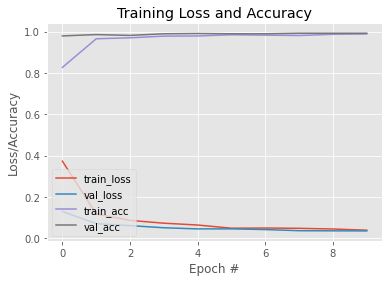

In [56]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [63]:
path = './dataset/new/nomask2.jpg'
image1 = load_img(path, target_size=(224, 224))
image1 = img_to_array(image)
image1 = preprocess_input(image)

print(image1.shape)

(224, 224, 3)


In [79]:
face = np.expand_dims(testX[1], axis=0)
print(face.shape)

(1, 224, 224, 3)


In [83]:
print(type(testY[1]))

<class 'numpy.ndarray'>


In [82]:
val = model.predict(face)[0]
print(val)

[0.999995]


In [96]:
path = './dataset/new/.jpg'
image1 = load_img(path, target_size=(224, 224))
image1 = img_to_array(image1)
image1 = preprocess_input(image1)
img = np.array(image1, dtype="float32")
print(type(img))

<class 'numpy.ndarray'>


In [97]:
face = np.expand_dims(img, axis=0)
print(face.shape)

(1, 224, 224, 3)


In [98]:
val = model.predict(face)[0]
print(val)

[0.00211051]


In [102]:
import cv2
import mtcnn

In [101]:
img = cv2.imread('./dataset/new/both.jpg')
cv2.imshow('image', img)
cv2.waitKey(0)

-1

In [110]:
def get_face(img, box):
    x1, y1, width, height = box
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    face = img[y1:y2, x1:x2]
    return face, (x1, y1), (x2, y2)

In [111]:
def plt_show(cv_img):
    img_rgb = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.show()

In [103]:
faceDetector = mtcnn.MTCNN()

In [106]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
results = faceDetector.detect_faces(img_rgb)


TypeError: list indices must be integers or slices, not str

In [109]:
for res in results:
    if res['confidence'] > .9:
        print(res['box'])

[697, 107, 199, 261]
[186, 79, 200, 268]


In [121]:
test_res_path = './dataset/new/bothResult.jpg'

(1, 224, 224, 3)
(1, 224, 224, 3)


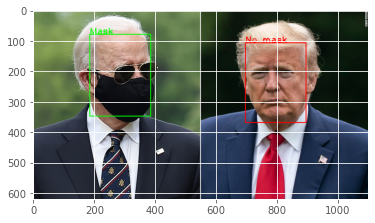

In [126]:
for res in results:
    face, pt_1, pt_2 = get_face(img_rgb, res['box'])
    check = False
    name = 'No mask'
    
    if res['confidence'] > .9:
        face = cv2.resize(face, (224, 224))
        face = img_to_array(face)
        face = preprocess_input(face)
        face = np.array(face, dtype="float32")
        face = np.expand_dims(face, axis=0)
        val = model.predict(face)[0]
        if val > .5:
            check = True
            name = 'Mask'
        
        print(face.shape)
    
    
    if check:        
        cv2.rectangle(img, pt_1, pt_2, (0, 255, 0), 2)
        cv2.putText(img, name, pt_1, cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 2)
        
    else:
        cv2.rectangle(img, pt_1, pt_2, (0, 0, 255), 2)
        cv2.putText(img, name, pt_1, cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 2)

cv2.imwrite(test_res_path, img)       
plt_show(img)

In [127]:
print("[INFO] saving mask detector model...")
model.save('mask_no_mask.h5')

[INFO] saving mask detector model...
